## Project 5: Vehicle Detection and Tracking

In [33]:
# Import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob

%matplotlib inline

# Import libaries for video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Import machine learning packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from skimage.feature import hog


In [42]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

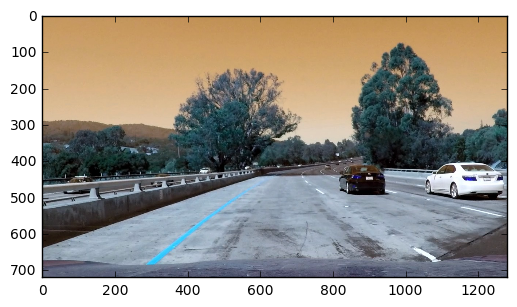

In [2]:
# load an image
img1 = cv2.imread('test_images/test1.jpg')
plt.imshow(img1)

### draw a window

In [3]:
# draw a window
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

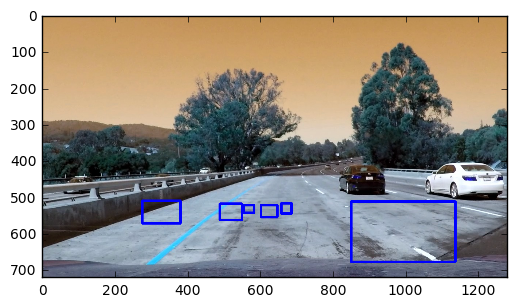

In [4]:
# Here are the bounding boxes I used
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

img_box = draw_boxes(img1, bboxes, color=(0, 0, 255), thick=6)
plt.imshow(img_box)

## color histogram features

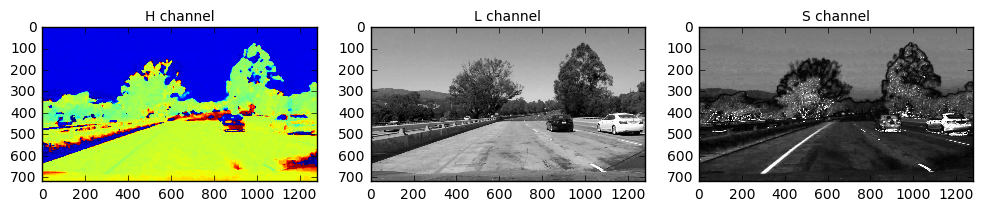

In [5]:
# convert image to hls space
hls = cv2.cvtColor(img1, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]


# plot the tree changes
# visualize
f, ((ax1, ax2,ax3)) = plt.subplots(1,3, figsize=(10, 9))
f.tight_layout()

ax1.imshow(h_channel)
ax1.set_title('H channel', fontsize=10)

ax2.imshow(l_channel, cmap='gray')
ax2.set_title('L channel', fontsize=10)

ax3.imshow(s_channel, cmap='gray')
ax3.set_title('S channel', fontsize=10)

### histogram

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

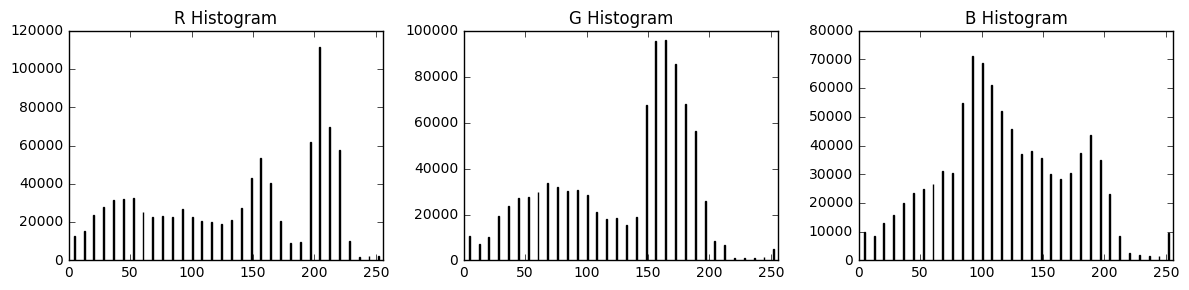

In [7]:
rh, gh, bh, bincen, feature_vec = color_hist(img1, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

In [8]:
### explore color spaces

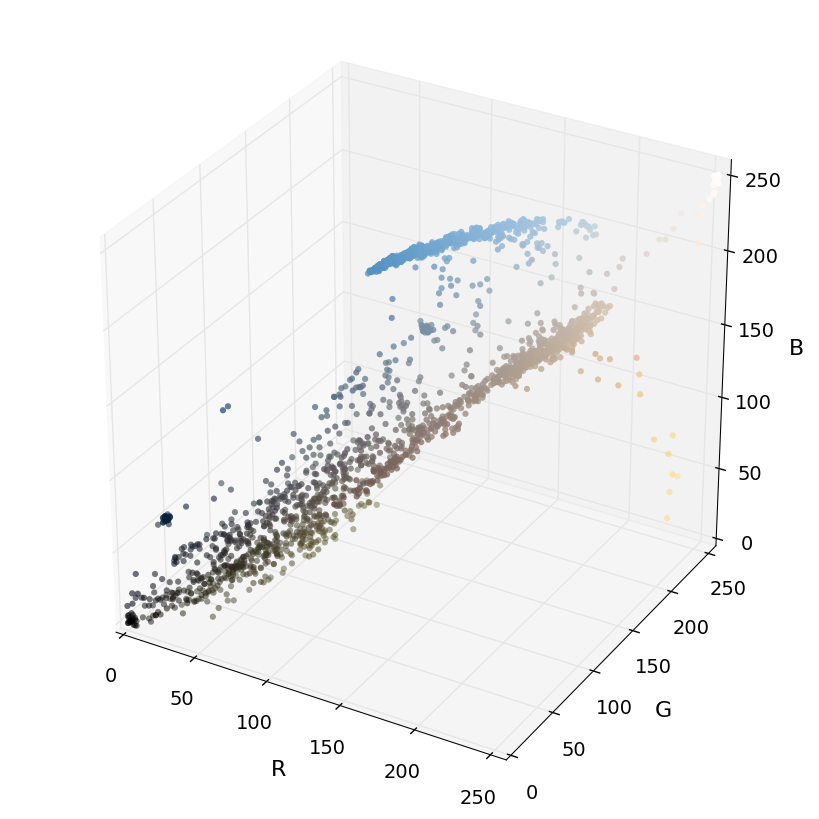

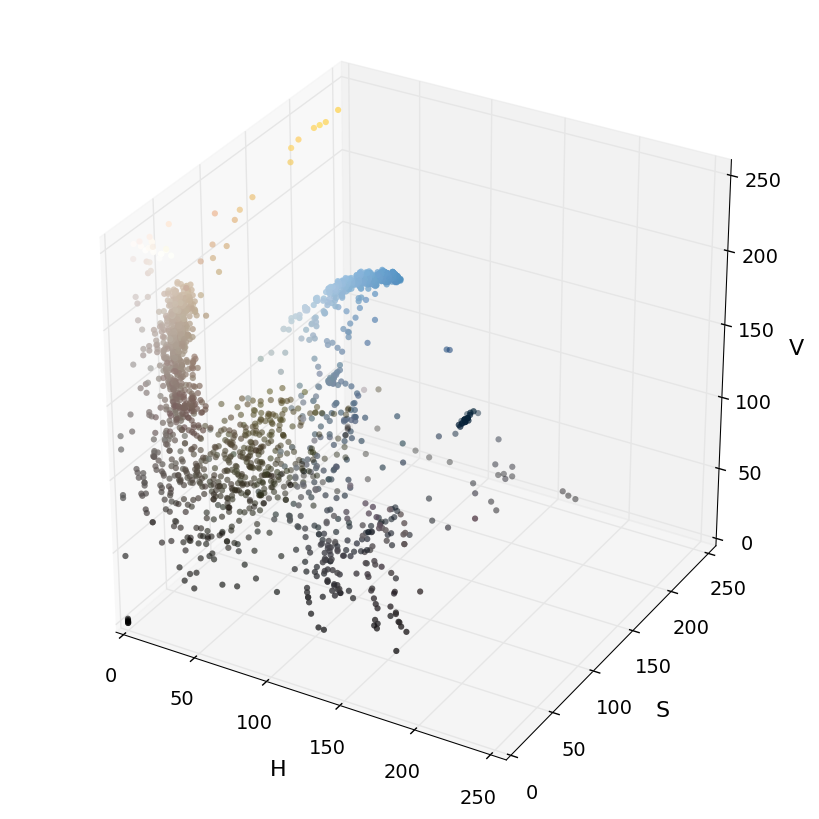

In [9]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = img1

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb , axis_labels=list("HSV"))
plt.show()

### spacial bin of color

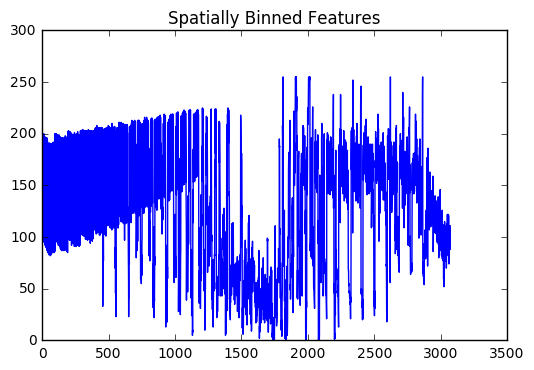

In [10]:
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = img1

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

In [11]:
### data exploration

In [29]:
images = glob.glob('/Users/daruizhang/Documents/car_img/*.png')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

Your function returned a count of 30  cars and 30  non-cars
of size:  (64, 64, 3)  and data type: float32


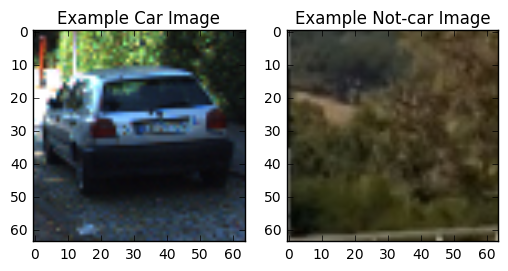

In [32]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### HOG

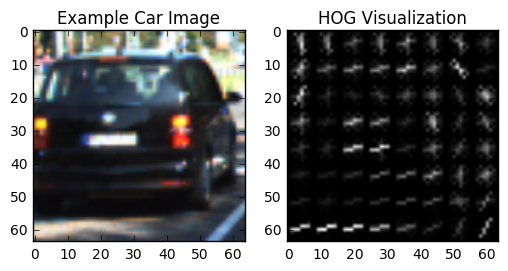

In [34]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


In [40]:
features.shape

(7, 7, 2, 2, 9)

### Extract features

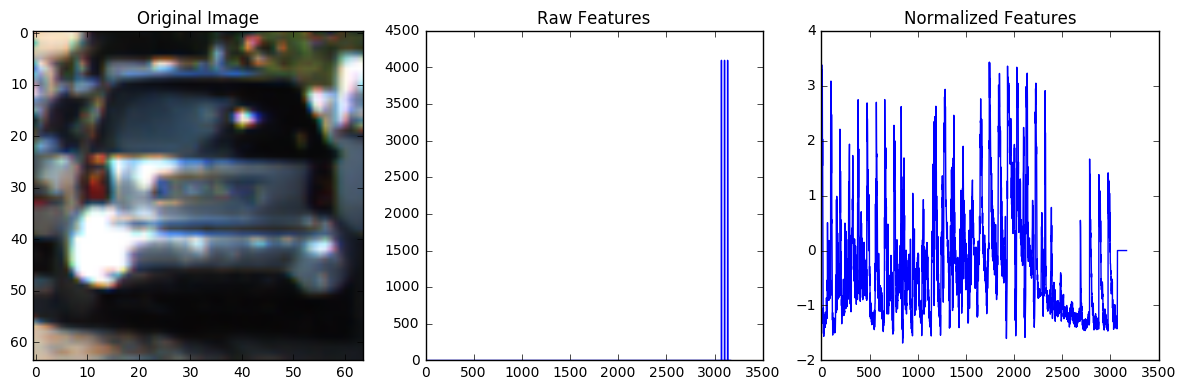

In [41]:
# extract features
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###### TODO ###########
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

        
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## classifer

In [12]:
# use a linear svc classifer
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 2, 2])

clf = SVC()
clf.fit(X, y) 
SVC(kernel='linear')
print(clf.predict([[-0.8, -1]]))

[1]


In [43]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
0.03 Seconds to train SVC...
Test Accuracy of SVC =  0.9167
My SVC predicts:  [ 1.  0.  0.  1.  0.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  0.  1.  1.  0.]
0.00121 Seconds to predict 10 labels with SVC


## train test split

In [44]:
## train test split

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features



# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

0.1 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9167
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  1.  0.  0.  0.]
0.00121 Seconds to predict 10 labels with SVC


## sliding window

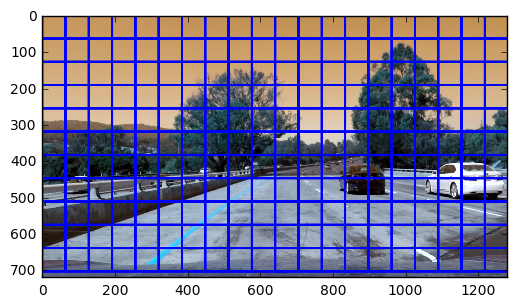

In [45]:
image = img1

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## search and classify